Avvertenza
Caricare i vari dataframe/geodataframe all'inizio del notebook e analizzare con attenzione i dati che sono inseriti, per capire bene le relazioni tra loro.


Situazione


Il Comune di Milano vuole fare un'analisi riguardante le aree di sosta per il parcheggio delle biciclette.
Ha messo a disposizione quindi tre dataset (in allegato) e ha chiesto di avere un report con le seguenti informazioni:


- una lista (elenco) delle aree di sosta, indicando il nome della via, il numero civico e il numero di posti totali per le biciclette
- una lista (elenco) analogo al precedente ma con anche  l'indicazione del quartiere
- i nomi dei quartieri in cui non ci sono aree di sosta;
- una mappa di Milano con l'indicazione dei quartieri in cui non ci sono aree di sosta
- il nome del quartiere con più aree di sosta;
- una mappa di Milano con l'indicazione del quartiere con più aree di sosta;
- i nomi dei quartieri con un numero di aree di sosta minori della media;

- una mappa di Milano con l'indicazione  dei quartieri con un numero di aree di sosta minori della media;
- una mappa di Milano con i diversi quartieri contornati in nero e l'indicazione delle aree di sosta, sottoforma di punti rossi;
- una mappa di Milano con i diversi quartieri colorati a seconda del numero di aree di sosta presenti, con una legenda che indichi il significato dei colori;

Richiesta

Creare un notebook Python che permetta di avere tutte le informazioni richieste sopra, Prevedere inoltre la possibilità per l'utente di avere le seguenti informazioni aggiuntive:


- data una via (inserita dall'utente), avere le aree di sosta di quella via

- dato un quartiere (inserito dall'utente), avere la mappa di quel quartiere con l'indicazione della posizione delle aree di sosta
- date le coordinate geografiche di un punto (inserite dall'utente), avere una mappa che visualizzi le aree di sosta a meno di 500 m da quel punto;



Controllare che l'input dell'utente sia accettabile.

In [ ]:
# import modulo os e installazione di rtree e altro per far funzionare l'sjoin
import os
!pip install rtree
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
os.chdir("/content/spatialindex-src-1.8.5")
!./configure
!make
!make install
!ldconfig

In [ ]:
!pip install geopandas
!pip install contextily

%matplotlib inline

import pandas as pd
import geopandas
import contextily 
import xyzservices.providers as xyz
import matplotlib.pyplot as plt

from shapely.geometry import LineString
from shapely.geometry import Point
from google.colab import drive
drive.mount("/content/drive")

In [3]:
Comuni = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Regioni/Limiti01012021_g/Com01012021_g")
Regioni = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Regioni/Limiti01012021_g/Reg01012021_g") 
Province = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Regioni/Limiti01012021_g/ProvCM01012021_g")
Fiumi = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Corsi_Acqua/Corsi_acqua_Piano_di_Gestione.zip") 
Fontanelle = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Fontane/Fontanelle.zip")
Autostrade = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Autostrade/Autostrade_10000_CT10_line.zip")
Piste_Ciclabi = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/BikeCiclabili/bike_ciclabili.zip")

Quartieri = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/Distretti/ds964_nil_wm.zip")
Aree_Sosta = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/EsercizioRiepilogativo/bike_areesosta.zip")
Stradario = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GEOPANDAS/EsercizioRiepilogativo/stradario.csv")

In [4]:
Quartieri.head(5)

ID_NIL  ...                                           geometry
0      48  ...  POLYGON ((9.15422 45.43775, 9.15419 45.43707, ...
1      64  ...  POLYGON ((9.10623 45.49016, 9.10295 45.48939, ...
2      67  ...  POLYGON ((9.15636 45.48785, 9.15724 45.48721, ...
3      81  ...  POLYGON ((9.16803 45.52234, 9.16687 45.52027, ...
4      84  ...  POLYGON ((9.20040 45.52848, 9.20055 45.52828, ...

[5 rows x 9 columns]

In [5]:
Aree_Sosta.head(5)

id_amat  ...                  geometry
0        2  ...  POINT (9.17821 45.42991)
1        4  ...  POINT (9.16829 45.51697)
2        8  ...  POINT (9.08480 45.47628)
3        9  ...  POINT (9.15673 45.48228)
4       10  ...  POINT (9.12054 45.45506)

[5 rows x 12 columns]

In [6]:
Stradario.head(5)

CODICE_VIA AREA DESCRIZIONE_VIA  CIVICO BARRATO  CAP  SEZIONE  MUNICIPIO
0        4377  VIA  8 OTTOBRE 2001      12     NaN  138      916          4
1        3123  VIA     A.DEL SARTO       1     NaN  129      665          3
2        3123  VIA     A.DEL SARTO       3     NaN  129      665          3
3        3123  VIA     A.DEL SARTO       4     NaN  129      665          3
4        3123  VIA     A.DEL SARTO       5     NaN  129      665          3

#1.   una lista (elenco) delle aree di sosta, indicando il nome della via, il numero civico e il numero di posti totali per le biciclette



Converto in un valore numerico

In [7]:
Aree_Sosta["id_via"] = pd.to_numeric(Aree_Sosta["id_via"])
Stradario["CODICE_VIA"] = pd.to_numeric(Stradario["CODICE_VIA"])

In [8]:
Stradario_sd = Stradario.drop_duplicates(subset=["CODICE_VIA"])

In [9]:
Merge_AreeSosta_Stradario = Aree_Sosta.merge(Stradario_sd, how="left", left_on='id_via', right_on='CODICE_VIA')
Merge_AreeSosta_Stradario

id_amat  id_via num_civico municipio  ... BARRATO    CAP  SEZIONE  MUNICIPIO
0           2  5339.0          0         5  ...     NaN  142.0   2066.0        5.0
1           4  1545.0         21         9  ...     NaN  161.0   1216.0        9.0
2           8  6330.0         42         7  ...     NaN  153.0   2117.0        7.0
3           9  7165.0          4         8  ...     NaN  149.0    444.0        8.0
4          10  6660.0          5         6  ...     NaN  147.0   1032.0        6.0
...       ...     ...        ...       ...  ...     ...    ...      ...        ...
1517     3232  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1518     3233  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1519     3234  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1520     3235  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1521     3243  4290.0         36         5  ...     NaN  139.0   1855.0        4.0

[1522 rows x 20 columns]

In [10]:
Merge_AreeSosta_Stradario[["DESCRIZIONE_VIA", "CIVICO", "stalli_tot"]]

DESCRIZIONE_VIA  CIVICO  stalli_tot
0       ABBIATEGRASSO     1.0          15
1              AFFORI     1.0          10
2     AIRAGHI GAETANO     3.0           5
3             ALCUINO     1.0           5
4            ALLODOLA     5.0           4
...               ...     ...         ...
1517      CANDIANI G.     5.0          12
1518      CANDIANI G.     5.0          10
1519      CANDIANI G.     5.0          12
1520      CANDIANI G.     5.0          58
1521      SAN DIONIGI     1.0          30

[1522 rows x 3 columns]

# 2.   una lista (elenco) analogo al precedente ma con anche l'indicazione del quartiere



-----------------------------

In [11]:
Join_Merge_Quartieri = geopandas.sjoin(Merge_AreeSosta_Stradario, Quartieri, op='within', how='left')
Join_Merge_Quartieri

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


id_amat  id_via num_civico  ...   Shape_Leng    Shape_Area OBJECTID
0           2  5339.0          0  ...  8831.940397  3.232115e+06    148.0
1           4  1545.0         21  ...  6470.396969  2.070816e+06    158.0
2           8  6330.0         42  ...  6962.785127  1.645797e+06    100.0
3           9  7165.0          4  ...  3800.750663  9.096022e+05     91.0
4          10  6660.0          5  ...  8442.031660  2.644338e+06    176.0
...       ...     ...        ...  ...          ...           ...      ...
1517     3232  1242.0         72  ...  5740.970581  1.913060e+06    162.0
1518     3233  1242.0         72  ...  5740.970581  1.913060e+06    162.0
1519     3234  1242.0         72  ...  5740.970581  1.913060e+06    162.0
1520     3235  1242.0         72  ...  5740.970581  1.913060e+06    162.0
1521     3243  4290.0         36  ...  7108.599989  1.736689e+06    150.0

[1522 rows x 29 columns]

In [12]:
Join_Merge_Quartieri[["DESCRIZIONE_VIA", "CIVICO", "stalli_tot", "NIL"]]

DESCRIZIONE_VIA  ...                                                NIL
0       ABBIATEGRASSO  ...  STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
1              AFFORI  ...                                             AFFORI
2     AIRAGHI GAETANO  ...                                      QUINTO ROMANO
3             ALCUINO  ...                                           PORTELLO
4            ALLODOLA  ...                                        LORENTEGGIO
...               ...  ...                                                ...
1517      CANDIANI G.  ...                                             BOVISA
1518      CANDIANI G.  ...                                             BOVISA
1519      CANDIANI G.  ...                                             BOVISA
1520      CANDIANI G.  ...                                             BOVISA
1521      SAN DIONIGI  ...                                       SCALO ROMANA

[1522 rows x 4 columns]

# 3 i nomi dei quartieri in cui non ci sono aree di sosta;

In [13]:
Quartieri_Senza_AreeSosta = Quartieri[~Quartieri.intersects(Aree_Sosta.unary_union)]
Quartieri_Senza_AreeSosta

ID_NIL  ...                                           geometry
1       64  ...  POLYGON ((9.10623 45.49016, 9.10295 45.48939, ...
5       63  ...  POLYGON ((9.08375 45.48485, 9.08280 45.48521, ...
22      75  ...  POLYGON ((9.13009 45.50820, 9.13016 45.50784, ...
23      47  ...  POLYGON ((9.16112 45.42589, 9.16270 45.42544, ...
24      39  ...  POLYGON ((9.21047 45.39699, 9.21039 45.39698, ...
28      88  ...  POLYGON ((9.07309 45.50604, 9.07326 45.50589, ...
36      87  ...  POLYGON ((9.04687 45.46276, 9.04688 45.46276, ...
46      40  ...  POLYGON ((9.18364 45.40122, 9.18442 45.40004, ...
48      31  ...  POLYGON ((9.27271 45.46079, 9.27276 45.46072, ...
54      34  ...  POLYGON ((9.24507 45.41742, 9.24303 45.41508, ...
80      73  ...  POLYGON ((9.09928 45.53128, 9.09932 45.53118, ...
82      86  ...  POLYGON ((9.13886 45.42855, 9.13901 45.42836, ...

[12 rows x 9 columns]

In [14]:
Quartieri_Senza_AreeSosta[["NIL"]]

NIL
1                   TRENNO
5                   FIGINO
22              STEPHENSON
23               CANTALUPA
24              QUINTOSOLE
28   PARCO BOSCO IN CITTA'
36                 ASSIANO
46    RONCHETTO DELLE RANE
48  MONLUE' - PONTE LAMBRO
54             CHIARAVALLE
80         CASCINA MERLATA
82       PARCO DEI NAVIGLI

# 4 una mappa di Milano con l'indicazione dei quartieri in cui non ci sono aree di sosta

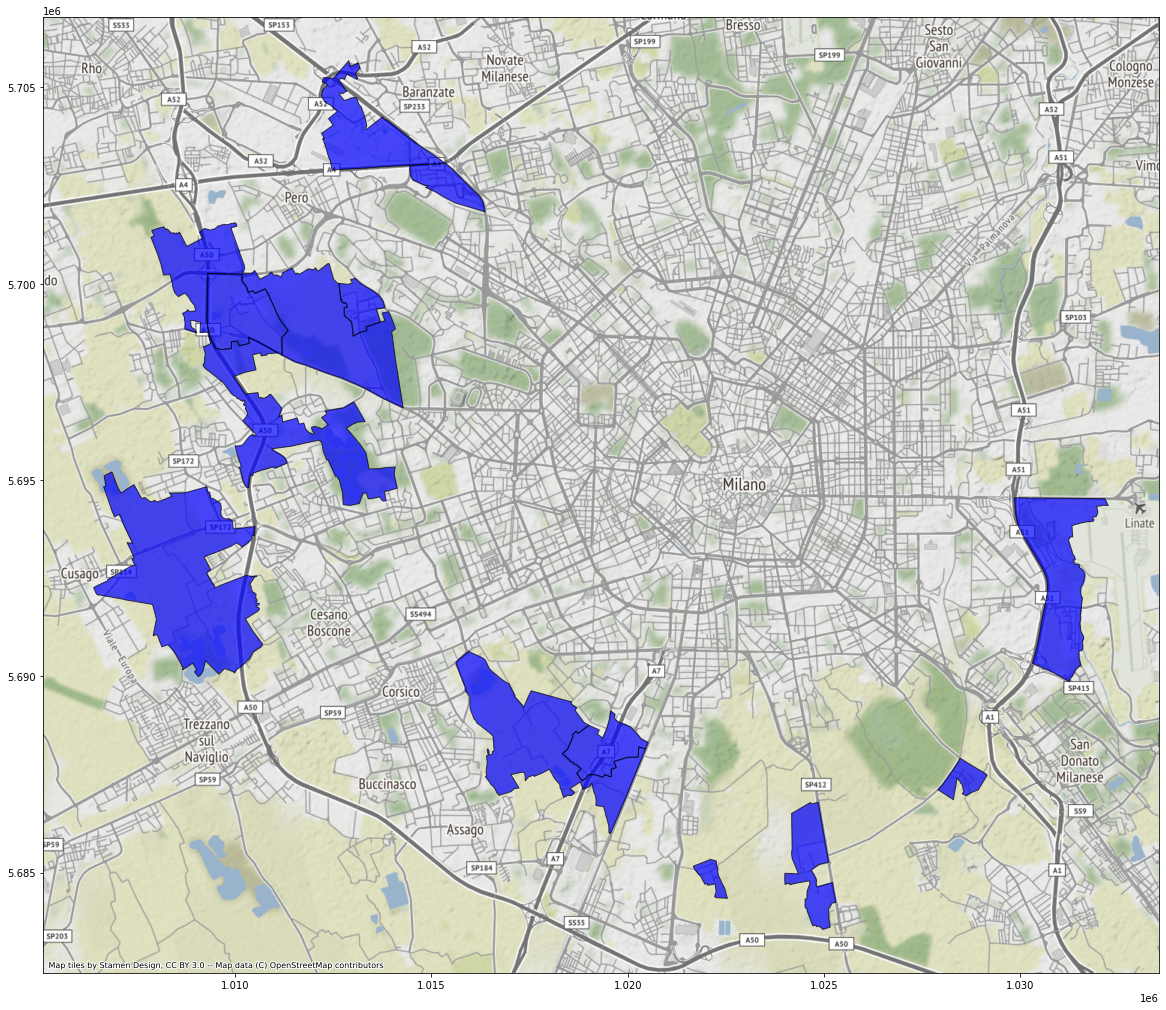

In [15]:
ax = Quartieri_Senza_AreeSosta.to_crs(epsg=3857).plot(figsize=(20,20),markersize = 20, alpha=0.7, facecolor="blue", edgecolor="Black") 
contextily.add_basemap(ax)

# 5 il nome del quartiere con più aree di sosta;

In [16]:
AreeSosta_Max = Join_Merge_Quartieri.groupby("NIL").count()["geometry"].idxmax()
AreeSosta_Max

'DUOMO'

#6 una mappa di Milano con l'indicazione del quartiere con più aree di sosta;

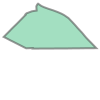

In [17]:
MaxSoste = Quartieri[Quartieri["NIL"] == "LORETO - CASORETTO - NOLO"].geometry.squeeze()
MaxSoste

In [18]:
Quartiere_Fontanelle_Max = Quartieri[Quartieri.within(MaxSoste)]

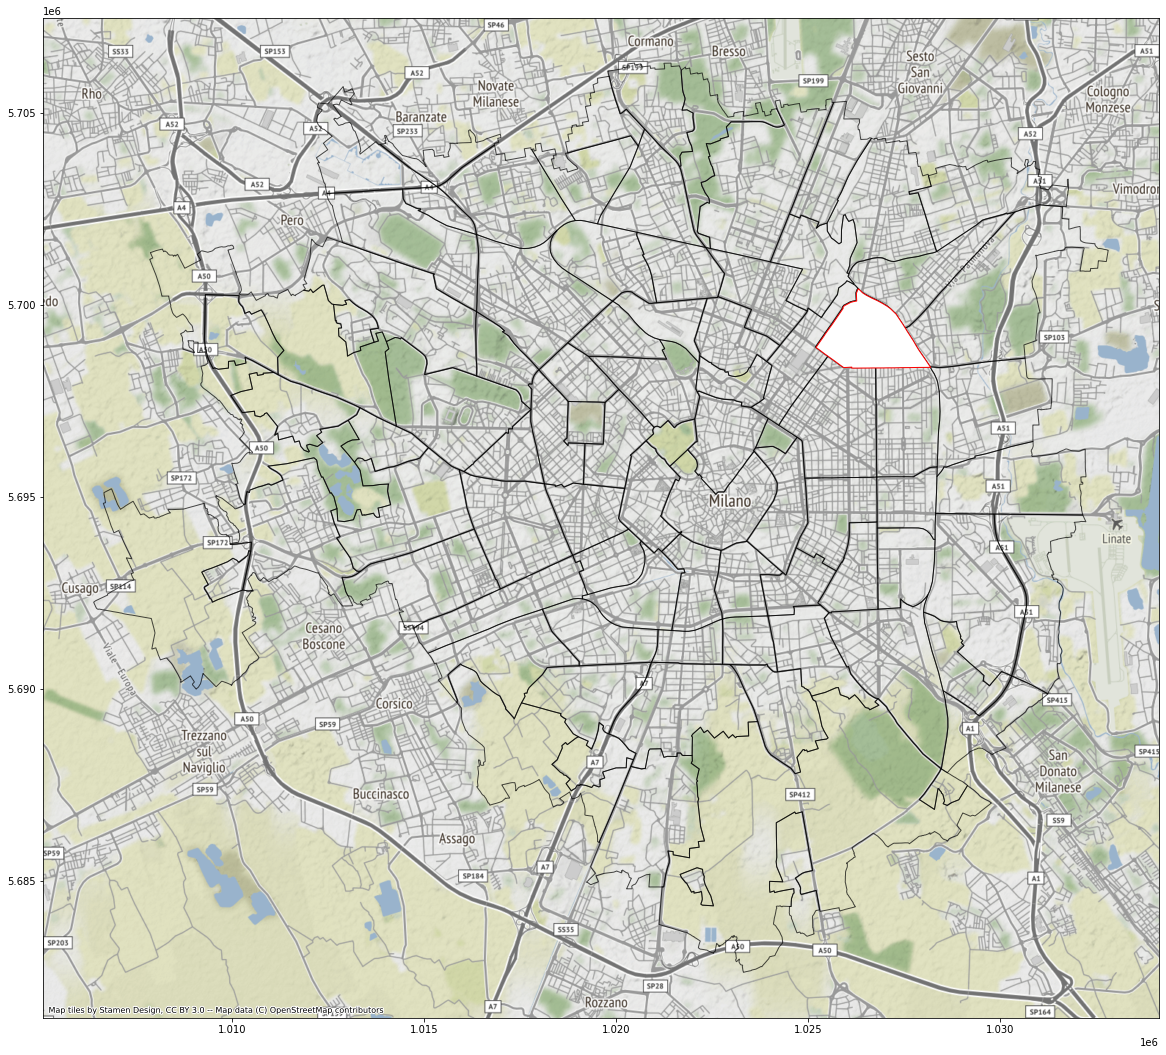

In [19]:
ax = Quartieri.to_crs(epsg=3857).plot(figsize=(20,20), alpha=0.7, facecolor="none",) 
Quartiere_Fontanelle_Max.to_crs(epsg= 3857).plot(ax=ax, facecolor = "white", edgecolor= "red")
contextily.add_basemap(ax)

#7 i nomi dei quartieri con un numero di aree di sosta minori della media;

In [20]:
GroupBy_Quartieri = Join_Merge_Quartieri.groupby("NIL").count()["geometry"].reset_index()
Quartiere_Max_Aree = GroupBy_Quartieri[GroupBy_Quartieri["geometry"] == GroupBy_Quartieri["geometry"].max()]
Quartiere_Max_Aree

NIL  geometry
17  DUOMO       136

In [21]:
Quartiere_Min_Aree = GroupBy_Quartieri[GroupBy_Quartieri["geometry"] <  GroupBy_Quartieri["geometry"].mean()]
Quartiere_Min_Aree.reset_index()

index                                             NIL  geometry
0       0                                         ADRIANO         5
1       1                                          AFFORI        11
2       4                                          BARONA        14
3       7                                       BOVISASCA         5
4       9                                        BRUZZANO         9
5      11                 CIMIANO - ROTTOLE - Q.RE FELTRE        12
6      13                                        COMASINA         1
7      15                          DE ANGELI - MONTE ROSA        19
8      16                                         DERGANO        12
9      18                                          FARINI         4
10     20                                        GHISOLFA         3
11     21                                     GIAMBELLINO        10
12     22                           GIARDINI P.TA VENEZIA         8
13     24    GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE        10
14     25                                 GRECO - SEGNANO         6
15     28                               LAMBRATE - ORTICA        11
16     34                    MAGGIORE - MUSOCCO - CERTOSA         1
17     35                       MONCUCCO - SAN CRISTOFORO        10
18     36                                       MORIVIONE        17
19     37                                        MUGGIANO         2
20     39                                     ORTOMERCATO         3
21     40                    PADOVA - TURRO - CRESCENZAGO        17
22     42                             PARCO DELLE ABBAZIE         1
23     43                      PARCO FORLANINI - CAVRIANO         4
24     44                                      PARCO NORD         3
25     45                                  PARCO SEMPIONE         3
26     50                      PORTA TICINESE - CONCHETTA        19
27     51                PORTA VIGENTINA - PORTA LODOVICA        12
28     52                                        PORTELLO        18
29     53                                      PTA ROMANA        16
30     55                                            QT 8        14
31     56                                  QUARTO CAGNINO         5
32     57               QUARTO OGGIARO - VIALBA - MUSOCCO        16
33     58                                   QUINTO ROMANO         5
34     59                         ROGOREDO - SANTA GIULIA         3
35     60  RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO         6
36     61                                         ROSERIO         1
37     62                                        SAN SIRO        12
38     64                                    SCALO ROMANA        10
39     66                              STADIO - IPPODROMI         9
40     68           TALIEDO - MORSENCHIO - Q.RE FORLANINI         7
41     69                                         TIBALDI         4
42     70                                       TRE TORRI        14
43     71                               TRIULZO SUPERIORE         1
44     72                    UMBRIA - MOLISE - CALVAIRATE        16
45     73                         VIGENTINO - Q.RE FATIMA        12
46     74             VILLAPIZZONE - CAGNOLA - BOLDINASCO        14
47     75                                      XXII MARZO        19

#8 una mappa di Milano con l'indicazione dei quartieri con un numero di aree di sosta minori della media;

In [22]:
Merge_Quartieri_Minori = Quartieri.merge(Quartiere_Min_Aree, how="inner", on='NIL')
Merge_Quartieri_Minori

ID_NIL  ... geometry_y
0       48  ...          6
1       67  ...         18
2       81  ...          5
3       84  ...          3
4       76  ...         16
5       61  ...          5
6       60  ...          9
7       62  ...          5
8       57  ...         12
9       82  ...          1
10      43  ...          4
11      13  ...          6
12      58  ...         19
13      78  ...          4
14      83  ...          9
15      66  ...         14
16       8  ...          3
17      46  ...         14
18      71  ...         14
19      32  ...          1
20      27  ...         16
21      30  ...          7
22      59  ...         14
23      37  ...         17
24      38  ...         12
25      29  ...          3
26      54  ...          2
27      44  ...         19
28      28  ...         16
29      74  ...          1
30      19  ...         17
31      41  ...         10
32      70  ...          3
33      85  ...          1
34      23  ...         11
35       5  ...         12
36      36  ...         10
37      26  ...         19
38      18  ...         12
39      79  ...         12
40      24  ...          4
41       3  ...          8
42      80  ...         11
43      45  ...         10
44      72  ...          1
45      49  ...         10
46      33  ...          3
47      17  ...          5

[48 rows x 10 columns]

TypeError: ignored

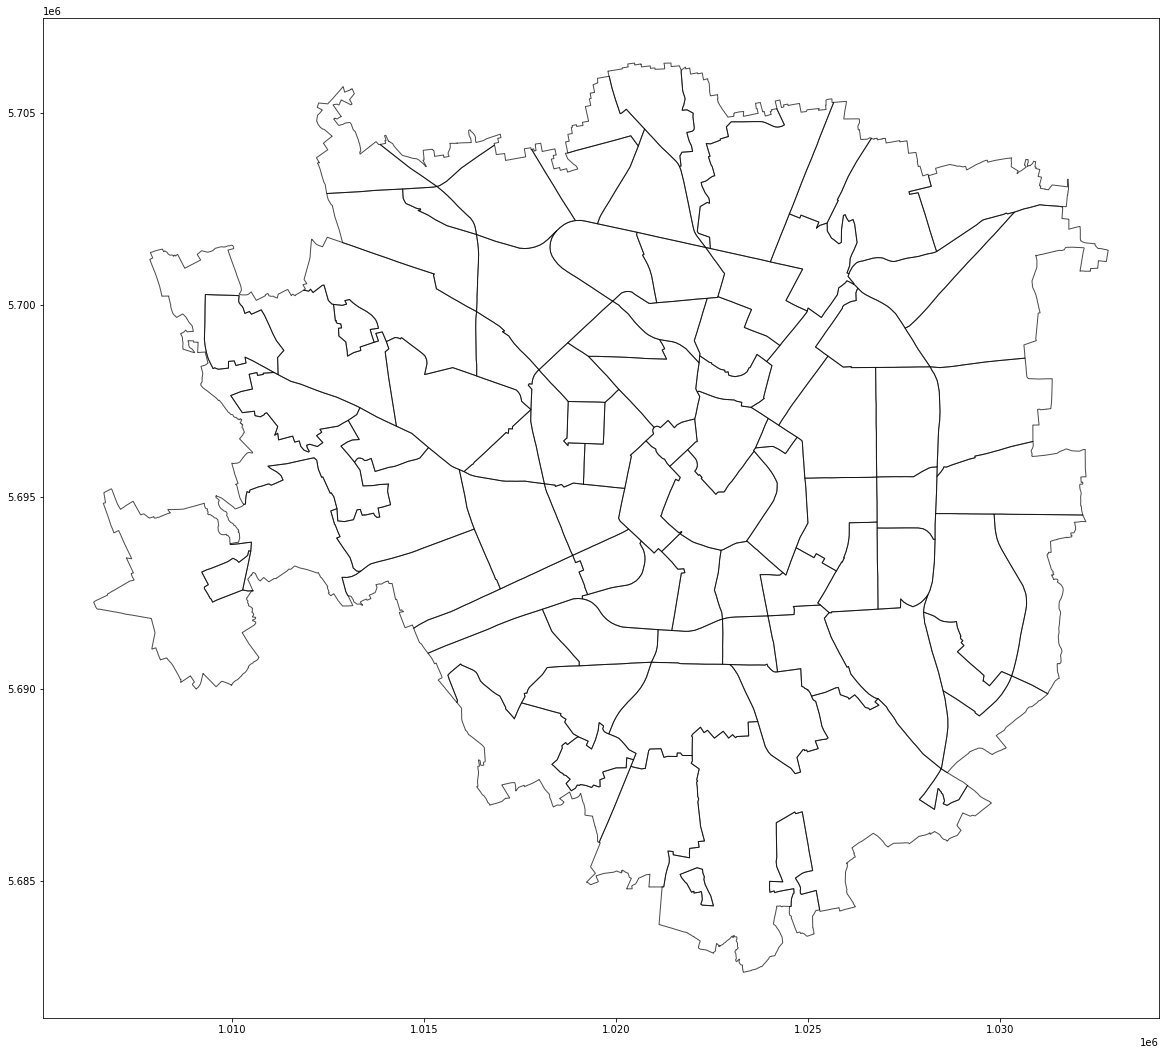

In [23]:
ax = Quartieri.to_crs(epsg=3857).plot(figsize=(20,20), alpha=0.7, facecolor="none",) 
Merge_Quartieri_Minori["geometry_x"].plot(ax=ax, facecolor = "white", edgecolor= "red")
contextily.add_basemap(ax)

#9 una mappa di Milano con i diversi quartieri contornati in nero e l'indicazione delle aree di sosta, sottoforma di punti rossi;

#10 una mappa di Milano con i diversi quartieri colorati a seconda del numero di aree di sosta presenti, con una legenda che indichi il significato dei colori;

In [24]:
Count_Quartieri_SosteAree = Join_Merge_Quartieri.groupby("NIL").count()[["geometry"]].rename(columns ={"geometry" : "Totale_SostePresenti"}).reset_index()
Count_Quartieri_SosteAree

NIL  Totale_SostePresenti
0                                    ADRIANO                     5
1                                     AFFORI                    11
2   BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA                    31
3                                 BANDE NERE                    21
4                                     BARONA                    14
..                                       ...                   ...
71                         TRIULZO SUPERIORE                     1
72              UMBRIA - MOLISE - CALVAIRATE                    16
73                   VIGENTINO - Q.RE FATIMA                    12
74       VILLAPIZZONE - CAGNOLA - BOLDINASCO                    14
75                                XXII MARZO                    19

[76 rows x 2 columns]

In [25]:
Quartieri_SosteAree_Colorati = pd.merge(Quartieri,Count_Quartieri_SosteAree, on='NIL', how = "inner")
Quartieri_SosteAree_Colorati

ID_NIL  ... Totale_SostePresenti
0       48  ...                    6
1       67  ...                   18
2       81  ...                    5
3       84  ...                    3
4       20  ...                   36
..     ...  ...                  ...
71      68  ...                   36
72       2  ...                   70
73      33  ...                    3
74      17  ...                    5
75      53  ...                   27

[76 rows x 10 columns]

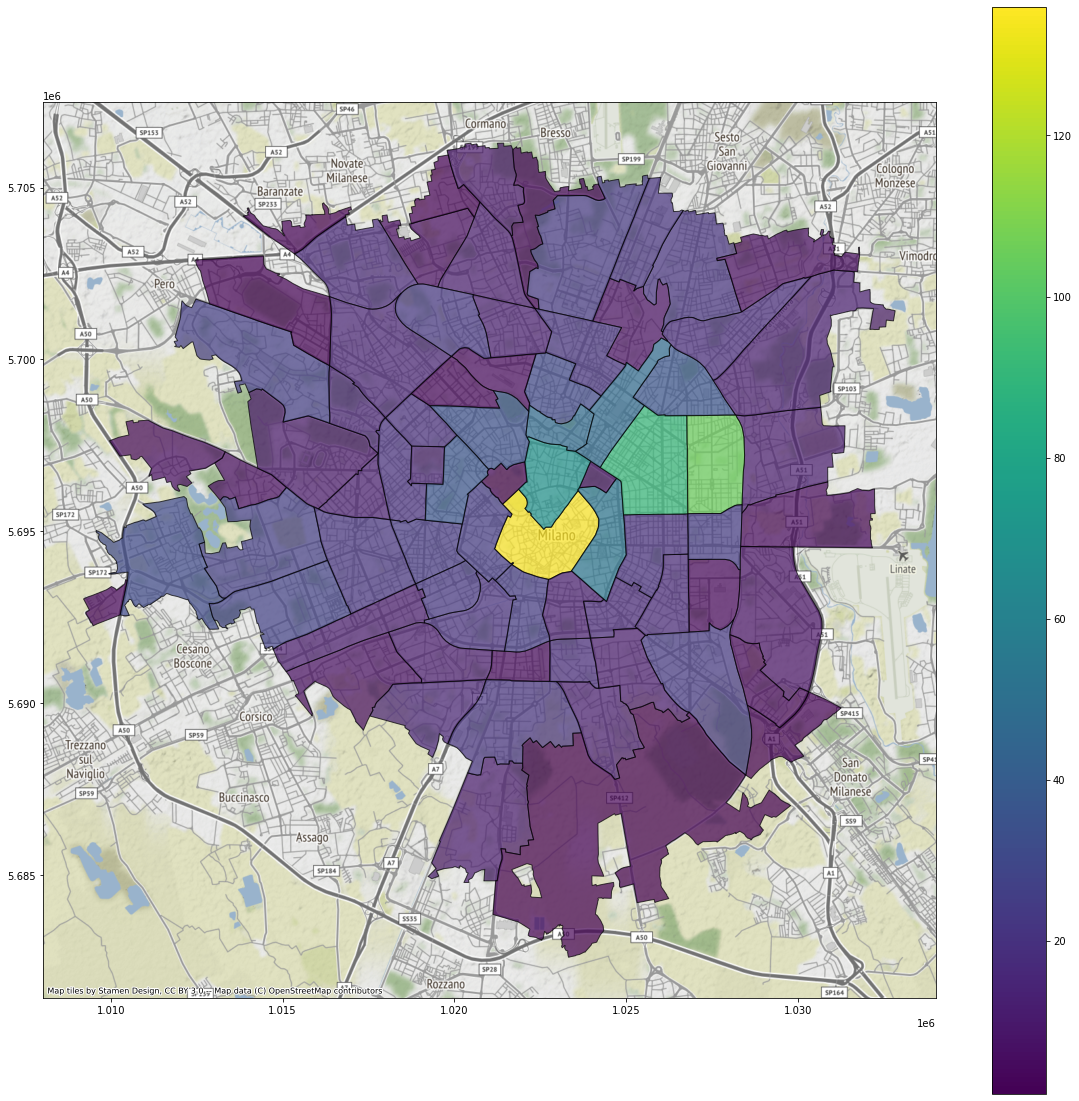

In [26]:
ax = Quartieri_SosteAree_Colorati.to_crs(epsg=3857).plot(figsize=(20,20),markersize = 20,column='Totale_SostePresenti',legend=True, alpha=0.7, edgecolor="Black") 
contextily.add_basemap(ax)

#

In [27]:
Merge_AreeSosta_Stradario

id_amat  id_via num_civico municipio  ... BARRATO    CAP  SEZIONE  MUNICIPIO
0           2  5339.0          0         5  ...     NaN  142.0   2066.0        5.0
1           4  1545.0         21         9  ...     NaN  161.0   1216.0        9.0
2           8  6330.0         42         7  ...     NaN  153.0   2117.0        7.0
3           9  7165.0          4         8  ...     NaN  149.0    444.0        8.0
4          10  6660.0          5         6  ...     NaN  147.0   1032.0        6.0
...       ...     ...        ...       ...  ...     ...    ...      ...        ...
1517     3232  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1518     3233  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1519     3234  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1520     3235  1242.0         72         9  ...     NaN  158.0   1954.0        9.0
1521     3243  4290.0         36         5  ...     NaN  139.0   1855.0        4.0

[1522 rows x 20 columns]

In [28]:
via = input("Inserisci una via: ")

if via in list(Merge_AreeSosta_Stradario.DESCRIZIONE_VIA):
  print(Merge_AreeSosta_Stradario[Merge_AreeSosta_Stradario["DESCRIZIONE_VIA"] == via])
else:
  print("La via da te inserita non è presente all'interno del geodataframe")


Inserisci una via: Milano
La via da te inserita non è presente all'interno del geodataframe


#dato un quartiere (inserito dall'utente), avere la mappa di quel quartiere con l'indicazione della posizione delle aree di sosta

Inserisci il nome di un quartiere: AFFORI


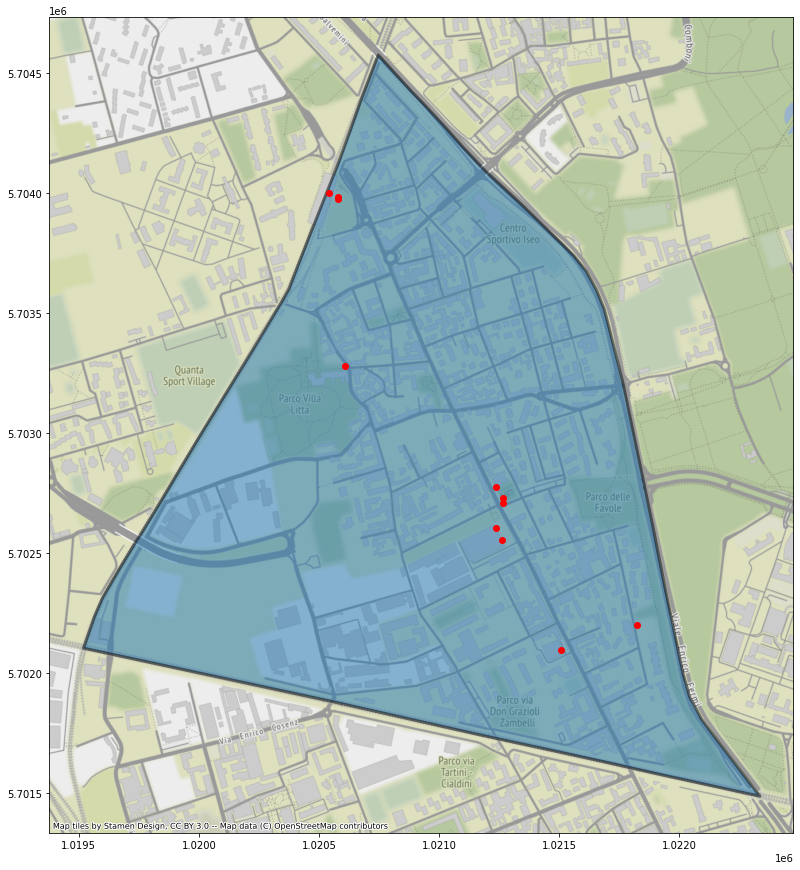

In [31]:
quartiere_input = input("Inserisci il nome di un quartiere: ")

if quartiere_input in list(Quartieri.NIL):

  quartiere= Quartieri[Quartieri["NIL"] == quartiere_input]

  aree_sosta_quartiere = Merge_AreeSosta_Stradario[Merge_AreeSosta_Stradario.intersects(quartiere.unary_union)]
  aree_sosta_quartiere

  ax = quartiere.to_crs(epsg=3857).plot(figsize=(15,15), alpha= 0.5, edgecolor= "Black", linewidth= 3)
  aree_sosta_quartiere.to_crs(epsg=3857).plot(ax=ax, color= "Red")
  contextily.add_basemap(ax)
else:
  print("Il quartiere da te inserito non è presente all'inetrnmo del geodataframe")